In [2]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance


CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


In [30]:
######### Step 1: Hyperparameter tuning round 1 WITH OVERSAMPLING not "balanced" weights

model_rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf=5, random_state = 42)
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

## tuning just on training data
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

## what if tuned in all data?
X_train = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - CIP_data_no_drop['Susceptible']

### parameters for search
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
space = dict()
space['n_estimators'] = np.arange(1, 201, 10)
space['max_features'] = ['sqrt']
space['max_depth'] = np.arange(1, 200, 10)
space['min_samples_split'] = [2,5,10]
space['min_samples_leaf'] = [1,2,4]


## find hyperparameters
search = RandomizedSearchCV(model_rf, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Hyperparameters: {'n_estimators': 191, 'min_samples_split': 5, 'max_features': 'sqrt'}

Best Score: 0.8150607541716982
Best Hyperparameters: {'n_estimators': 151, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 11}


In [31]:
##### Step 2: FEATURE ENGINEERING
## get better results using oversampling, not balanced dataset
#Best Hyperparameters: {'n_estimators': 151, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 11}
model_rf = RandomForestClassifier(n_estimators = 151, min_samples_split = 10, min_samples_leaf=1, max_features = 'sqrt', max_depth = 11, random_state = 42)


## Temporal split training data 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

model_fit = model_rf.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_rf.predict(X_test)

ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) 

perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

ROC_AUC_rf: 0.6367374658237016


Weight,Feature
0.0392 ± 0.0030,PREV_CLINIC
0.0284 ± 0.0018,MSM
0.0166 ± 0.0019,MSW
0.0020 ± 0.0006,Southeast
0.0010 ± 0.0003,Northeast
0.0009 ± 0.0001,Oth/Unk/Missing
0.0008 ± 0.0004,MSMW
-0.0010 ± 0.0010,DELTA_REGION
-0.0013 ± 0.0008,West
-0.0019 ± 0.0004,Southwest


In [32]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']

PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}" #works cos they are in same order as the x columns
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

Prev. Clinic0.039 +/- 0.002
MSM     0.028 +/- 0.001
MSW     0.017 +/- 0.001
Southeast0.002 +/- 0.000
Northeast0.001 +/- 0.000
Oth/Unk/Missing0.001 +/- 0.000
MSMW    0.000 +/- 0.000
West    -0.001 +/- 0.000
Change  -0.001 +/- 0.001
Southwest-0.002 +/- 0.000
Midwest -0.002 +/- 0.001
Prev. Region-0.005 +/- 0.001


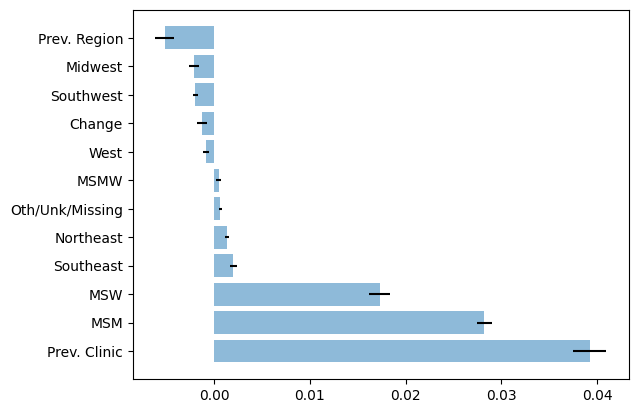

In [33]:
### graph feature engineering results 
feature_names = np.array(feature_names)
feature_names_by_importance = feature_names[PI.importances_mean.argsort()[::-1]]
mean_importance_by_importance = PI.importances_mean[PI.importances_mean.argsort()[::-1]]
std_importance_by_importance = PI.importances_std[PI.importances_mean.argsort()[::-1]]

plt.barh(y = range(mean_importance_by_importance.size), width =mean_importance_by_importance,
 xerr= std_importance_by_importance, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
plt.yticks(range(feature_names_by_importance.size), feature_names_by_importance)

#plt.savefig('Graphs/Features_by_importance_post_hyperparameter_random_forest.png')

In [35]:
##### HYPERPARAMETER TUNING without  prev_region, midwest, southwest, change, west

model_rf = RandomForestClassifier(n_estimators = 151, min_samples_split = 10, min_samples_leaf=1, max_features = 'sqrt', max_depth = 11, random_state = 42)

## what if tuned in all data?
X_train = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast',  'West', 'PREV_CLINIC']]
y_train = 1 - CIP_data_no_drop['Susceptible']

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

space = dict()
space['n_estimators'] = np.arange(1, 201, 10)
space['max_features'] = ['sqrt']
space['max_depth'] = np.arange(1, 200, 10)
space['min_samples_split'] = [2,5,10]
space['min_samples_leaf'] = [1,2,4]
search = RandomizedSearchCV(model_rf, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)

result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#Best Hyperparameters: {'n_estimators': 151, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 11}
# Didn't change



Best Score: 0.8071226189823892
Best Hyperparameters: {'n_estimators': 151, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 11}


In [41]:
###### Specificity and sensitivity of model on entire dataset
###### Dropping 
model_rf = RandomForestClassifier(n_estimators = 151, min_samples_split = 10, min_samples_leaf=1, max_features = 'sqrt', max_depth = 11, random_state = 42)

#loop setup
threshold_seq = np.linspace(0,1,101)

features = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast',  'West', 'PREV_CLINIC']
features = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[features]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[features]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

 #1. Create model using all data and get the apparent sensitivity and specificty 

model_fit_train = model_rf.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) 
#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  #print(threshold)
 
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)

ROC_AUC_rf: 0.6367374658237016
